# LiDAR Acquisition and Imputations - USGS

## Written by: Rodrigo Escandon

# Executive Summary
A process to extract LiDAR data from an AWS s3 bucket is showcased. Although this public data (USGS) has missing values, this process includes an interpolation section were those missing values are approximated using surrounded values.
These steps allowed the creation of both a digital elevation model (DEM) and a digital surface model (DSM) that can then be used with Aerial Imagery, Flood Maps and Forestry Maps to provide insights and make predictions.

In [1]:
import pdal
import json
import numpy.ma as ma
import numpy as np
import pandas as pd
import pyproj as proj
import rasterio as rs
from rasterio.fill import fillnodata
from matplotlib import pyplot as plt
from scipy.interpolate import griddata

In [2]:
print("PDAL",pdal.__version__)
print("JSON",json.__version__)
print("Numpy",np.__version__)
print("Pandas",pd.__version__)
print("PyProj",proj.__version__)
print("RasterIO",rs.__version__)

PDAL 3.2.0
JSON 2.0.9
Numpy 1.21.6
Pandas 1.3.5
PyProj 3.2.1
RasterIO 1.2.10


In [3]:
#Converting lat and long coordinates to EPSG:3857 tile coordinates for LiDAR layer acquisition
long=(-93.65091293275961,-93.63294662707723)
lat=(42.02346282729469,42.03680806944768)
loc=proj.Proj('EPSG:3857')
pol_x,pol_y=loc(long,lat)
state='IA' #State abbreviation
name='iowa' #File names (tif and laz)
point_typ='2' #Point classification (0 - Never Classified, 1 - Unclassified, 2 - Ground,
#3 - Low Vegetation, 4 - Medium Vegetation, 5 - High Vegetation, 6 - Building, 7 - Noise,
#9 - Water, 10 - Rail Road, 11 - Road

In [4]:
#Data conditions for LiDAR layer acquisition (DSM)
json_string_dsm={
    "pipeline": [
        {
"bounds": "(%s"% list(pol_x) + ",%s"% list(pol_y) + ")",
"filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"+"%s"% state+"_FullState/ept.json",
"type": "readers.ept",
"tag": "readdata"
        },
        {
            "limits": "Classification![7:7]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "assignment": "Classification[:]=0",
            "tag": "wipeclasses",
            "type": "filters.assign"
        },
        {
            "out_srs": "EPSG:26915",
            "tag": "reprojectUTM",
            "type": "filters.reprojection"
        },
        {
            "tag": "groundify",
            "type": "filters.csf"
        },
        {
            "limits": "Z[0:]",
            "type": "filters.range",
            "tag": "classify"
        },
        {
            "filename": "%s"% name+"_dsm"+".laz",
            "inputs": [ "classify" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
        {
            "filename": "%s"% name+"_dsm"+".tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        }
    ]
}

In [5]:
#Data conditions for LiDAR layer acquisition (DEM)
json_string_dem={
    "pipeline": [
        {
"bounds": "(%s"% list(pol_x) + ",%s"% list(pol_y) + ")",
"filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"+"%s"% state+"_FullState/ept.json",
"type": "readers.ept",
"tag": "readdata"
        },
        {
            "limits": "Classification![7:7]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "assignment": "Classification[:]=0",
            "tag": "wipeclasses",
            "type": "filters.assign"
        },
        {
            "out_srs": "EPSG:26915",
            "tag": "reprojectUTM",
            "type": "filters.reprojection"
        },
        {
            "tag": "groundify",
            "type": "filters.csf"
        },
        {
            "limits": "Classification[%s:" % point_typ+"%s]"% point_typ,
            "type": "filters.range",
            "tag": "classify"
        },
        {
            "filename": "%s"% name+"_dem"+".laz",
            "inputs": [ "classify" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
        {
            "filename": "%s"% name+"_dem"+".tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        }
    ]
}

In [6]:
def json_write(json_string,file_name):
    jsonString = json.dumps(json_string)
    jsonFile = open(file_name, "w")
    jsonFile.write(jsonString)
    jsonFile.close()
json_write(json_string_dsm,"iowa_dsm.json")
json_write(json_string_dem,"iowa_dem.json")

In [7]:
%%time
#Data acquisition from s3 bucket (DSM)
! pdal pipeline iowa_dsm.json

CPU times: user 1.79 s, sys: 516 ms, total: 2.31 s
Wall time: 1min 32s


In [8]:
%%time
#Data acquisition from s3 bucket (DEM)
! pdal pipeline iowa_dem.json

CPU times: user 1.59 s, sys: 471 ms, total: 2.07 s
Wall time: 1min 29s


In [9]:
name_dsm="iowa_dsm.tif"
im_dsm=rs.open('./'+name_dsm)

In [10]:
#Display Raster File Specifics
print(im_dsm.count)
print(im_dsm.height,im_dsm.width)
print(im_dsm.crs)

1
1493 1499
EPSG:26915


In [11]:
print(im_dsm.bounds)

BoundingBox(left=446112.5180587497, bottom=4652575.192733061, right=447611.5180587497, top=4654068.192733061)


In [12]:
im_dsm.tags(ns='IMAGE_STRUCTURE')

{'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND'}

In [13]:
print(im_dsm.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 1499, 'height': 1493, 'count': 1, 'crs': CRS.from_epsg(26915), 'transform': Affine(1.0, 0.0, 446112.5180587497,
       0.0, -1.0, 4654068.192733061)}


In [14]:
im_dsm.crs.wkt

'PROJCS["NAD83 / UTM zone 15N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26915"]]'

In [15]:
#Reading Raster File and Displaying Max and Min Values
read_dsm=im_dsm.read()
print(np.min(read_dsm)) #includes value that represents NAs
print(round(np.min(ma.masked_array(read_dsm,mask=read_dsm==-9999)))) #masks value that represents NAs
print(round(np.max(read_dsm)))

-9999.0
270
344


In [16]:
#Shape of DSM Raster File
read_dsm.shape

(1, 1493, 1499)

In [17]:
#Convert Raster File into Dataframe, and Drop NAs for Interpolated Values 
def NA_one(read):
    read=np.where(read==0,1,read)
    read=np.where(read==-9999,0,read)
    n_read=pd.DataFrame(read.copy().reshape([read.shape[1],read.shape[2]]))
    n_read=np.array(n_read,dtype="int8")
    mask=np.array(n_read!=0)
    n_fill=fillnodata(read,mask=mask,max_search_distance=100,smoothing_iterations=1000)
    n_fill=pd.DataFrame(n_fill.reshape([n_fill.shape[1],n_fill.shape[2]]))
    return n_fill
n_fill_dsm=NA_one(read_dsm)

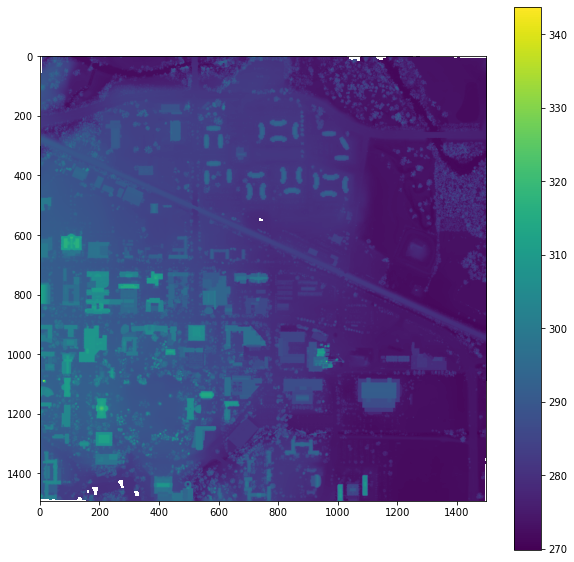

In [18]:
#Visualize Dataframe DSM, and displays areas where NAs are located (White)
plt.figure(figsize=(10,10))
plt.imshow(n_fill_dsm)
plt.colorbar()

In [19]:
%%time
#While loop to fill in missing values and Displays total missing values per loop
def NA_two(n_fill):
    while n_fill.isnull().sum().sum()>0:
        n_read=n_fill.copy()
        n_read=np.array(n_read,dtype="int8")
        mask=np.array(n_read!=0)
        n_fill=fillnodata(np.array(n_fill),mask=mask,max_search_distance=100,smoothing_iterations=1000)
        n_fill=pd.DataFrame(n_fill)
        print(n_fill.isnull().sum().sum())
    return n_fill
n_fill_dsm=NA_two(n_fill_dsm)

923
264
12
0
CPU times: user 16.7 s, sys: 180 ms, total: 16.8 s
Wall time: 16.8 s


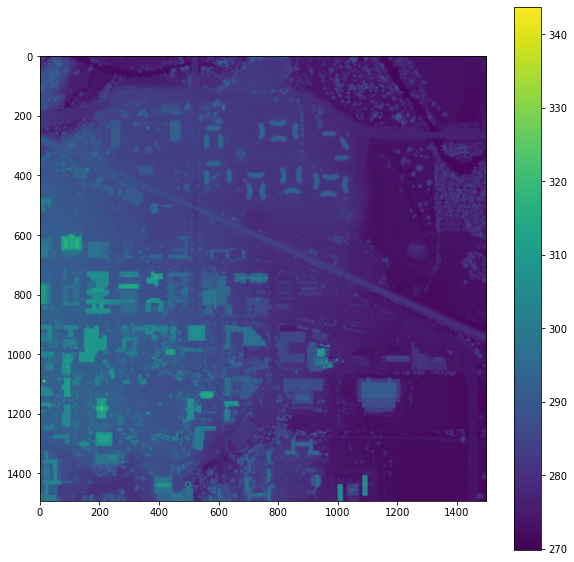

In [20]:
#Visualize Dataframe DSM with Interpolated Values
plt.figure(figsize=(10,10))
plt.imshow(n_fill_dsm)
plt.colorbar()

In [21]:
#Displaying DSM Max and Min Values
print(round(np.min(np.array(n_fill_dsm))))
print(round(np.max(np.array(n_fill_dsm))))

270
344


In [22]:
name_dem="iowa_dem.tif"
im_dem=rs.open('./'+name_dem)

In [23]:
#Reading Raster File and Displaying Max and Min Values
read_dem=im_dem.read()
print(np.min(read_dem)) #includes value that represents NAs
print(round(np.min(ma.masked_array(read_dem,mask=read_dem==-9999)))) #masks value that represents NAs
print(round(np.max(read_dem)))

-9999.0
270
300


In [31]:
#Shape of DEM Raster File
read_dem.shape

(1, 1493, 1498)

In [24]:
n_fill_dem=NA_one(read_dem)

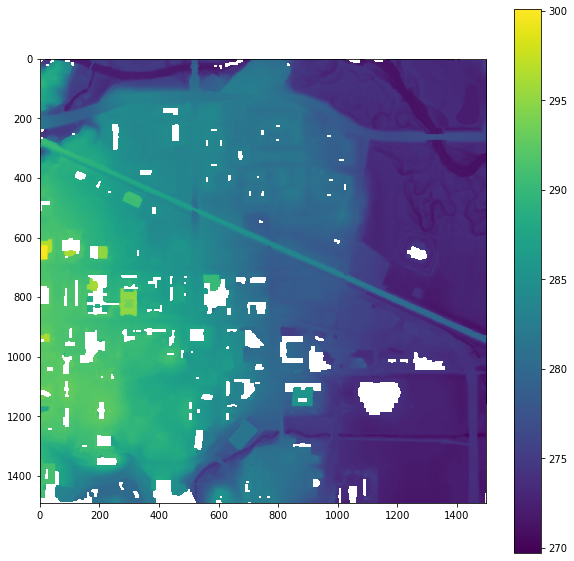

In [25]:
#Visualize Dataframe DEM, and displays areas where NAs are located (White)
plt.figure(figsize=(10,10))
plt.imshow(n_fill_dem)
plt.colorbar()

In [26]:
%%time
n_fill_dem=NA_two(n_fill_dem)

59921
50398
42721
36201
30613
25924
21969
18678
15869
13505
11456
9821
8470
7377
6467
5709
5082
4538
4050
3608
3206
2842
2563
2308
2068
1836
1612
1396
1188
988
836
710
592
482
382
290
206
130
62
2
0
CPU times: user 2min 54s, sys: 1.66 s, total: 2min 56s
Wall time: 2min 55s


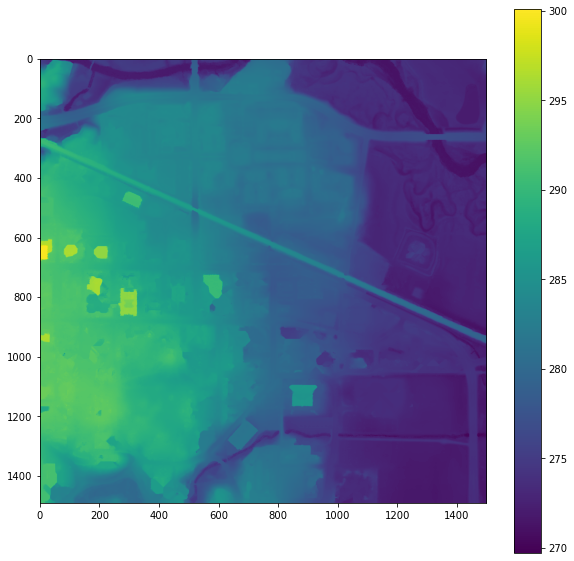

In [27]:
#Visualize Dataframe DEM with Interpolated Values
plt.figure(figsize=(10,10))
plt.imshow(n_fill_dem)
plt.colorbar()

In [28]:
#Displaying DEM Max and Min Values
print(round(np.min(np.array(n_fill_dem))))
print(round(np.max(np.array(n_fill_dem))))

270
300


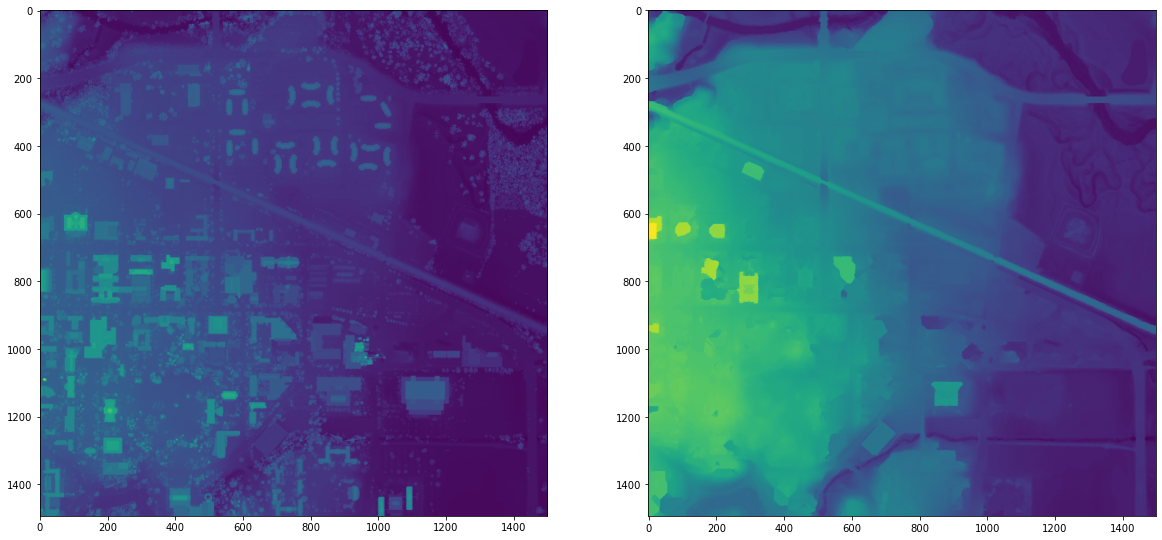

In [29]:
#Visualize Dataframe for both DSM and DEM data sets
figure,(ax1,ax2)=plt.subplots(1,2,figsize=(20,20))
ax1.imshow(n_fill_dsm)
ax2.imshow(n_fill_dem)